In [57]:
%matplotlib inline

In [58]:
import torch
from torch import nn, optim
from torchsummary import summary
import torchvision
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils import tensorboard as tb

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


In [60]:
augs = T.Compose([
    T.RandomRotation(degrees = 15),
    # T.Resize((40,40)),
    # T.RandomResizedCrop((32,32), scale = (0.6,1), ratio=(1,1)),
    T.ColorJitter(brightness=0.2, contrast = 0.2, hue = 0.2, saturation=0.2),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_augs=  T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

Load the Cifar10 dataset

In [61]:
batch_size_train = 64
batch_size_test = 64

train_data = torchvision.datasets.CIFAR10(root = './data',
                                          train = True,
                                          download=True,
                                          transform=augs)
test_data = torchvision.datasets.CIFAR10(root = './data',
                                          train = False,
                                          download=True,
                                          transform=test_augs)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size_train, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, shuffle = True)
print(train_loader)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

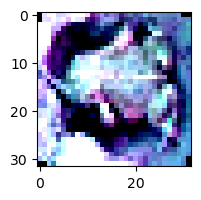

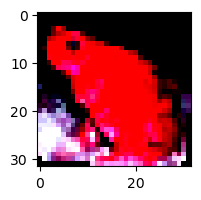

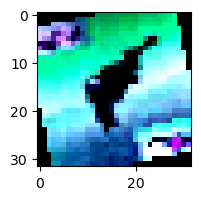

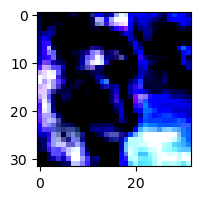

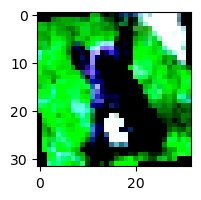

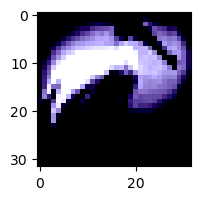

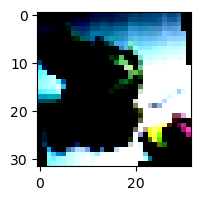

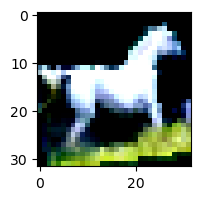

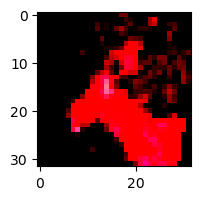

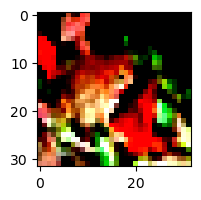

In [62]:
def imshow(img):
    plt.figure(figsize=(2,2))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in range(10):
    imshow(torchvision.utils.make_grid(images[i]))

Create the model

In [63]:
class ResBlock(nn.Module):

    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=(1,1), stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.layer(ResBlock, 64, num_blocks=2, stride=1)
        self.layer2 = self.layer(ResBlock, 128, num_blocks=2, stride=2)
        self.layer3 = self.layer(ResBlock, 256, num_blocks=2, stride=2)
        self.layer4 = self.layer(ResBlock, 512, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(512,10,bias = True),
            nn.Softmax(-1)
        )

    def layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

model = ResNet18()
model.to(device)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
         ResBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Initialize hyperparamters

In [64]:
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 4,verbose = True, min_lr = 0.00001)
num_epochs = 200

Train the model

In [65]:
train_acc_list = []
test_acc_list = []

train_loss_list = []
test_loss_list = []

es_count = 0 # Patience for LR scheduler
curr_epoch = 0
curr_loss = 0
best_test_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    curr_epoch = epoch
    if es_count == 15:
        print("Stop training")
        break
    model.train()
    train_loss = 0
    train_acc = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
        train_acc += accuracy.item()

    train_acc /= len(train_loader)
    train_loss /= len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    model.eval()

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
            test_acc += accuracy.item()

        test_acc /= len(test_loader)
        test_loss /= len(test_loader)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        if test_acc > best_test_acc:
            best_epoch = epoch
            best_test_acc = test_acc
            torch.save(model.state_dict(), "best_model.pth")

    scheduler.step(test_loss)

    if abs(test_loss - curr_loss) < 0.005 or test_loss > curr_loss:
        es_count += 1
        curr_loss = test_loss
    else:
        es_count = 0
        curr_loss = test_loss

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Acc: {train_acc:.4f} - Validation Acc: {test_acc:.4f}")


Epoch 1/200 - Training Acc: 0.3385 - Validation Acc: 0.4216
Epoch 2/200 - Training Acc: 0.4039 - Validation Acc: 0.4457
Epoch 3/200 - Training Acc: 0.4341 - Validation Acc: 0.4889
Epoch 4/200 - Training Acc: 0.4643 - Validation Acc: 0.5052
Epoch 5/200 - Training Acc: 0.4873 - Validation Acc: 0.5387
Epoch 6/200 - Training Acc: 0.5025 - Validation Acc: 0.5312
Epoch 7/200 - Training Acc: 0.5191 - Validation Acc: 0.5679
Epoch 8/200 - Training Acc: 0.5367 - Validation Acc: 0.5886
Epoch 9/200 - Training Acc: 0.5472 - Validation Acc: 0.5899
Epoch 10/200 - Training Acc: 0.5576 - Validation Acc: 0.5814
Epoch 11/200 - Training Acc: 0.5664 - Validation Acc: 0.6098
Epoch 12/200 - Training Acc: 0.5797 - Validation Acc: 0.6302
Epoch 13/200 - Training Acc: 0.5881 - Validation Acc: 0.6232
Epoch 14/200 - Training Acc: 0.5956 - Validation Acc: 0.6188
Epoch 15/200 - Training Acc: 0.6059 - Validation Acc: 0.6525
Epoch 16/200 - Training Acc: 0.6096 - Validation Acc: 0.6589
Epoch 17/200 - Training Acc: 0.61

Evaluate test accuracy

In [68]:

train_loss_list = np.array(train_loss_list)
test_loss_list = np.array(test_loss_list)
train_acc_list = np.array(train_acc_list)
test_acc_list = np.array(test_acc_list)

writer = SummaryWriter()

best_model = ResNet18()
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.to(device)

writer.flush()
for i in range(best_epoch):
    writer.add_scalars('Loss', {'Train': train_loss_list[i], 'Test': test_loss_list[i]}, i)
    writer.add_scalars('Accuracy', {'Train': train_acc_list[i], 'Test': test_acc_list[i]}, i)

writer.close()